# Neural style

## Preliminary

* Covariance

$$Cov[X,Y]=E[XY]-E[X]E[Y]$$

* 이 때,

$$ Var[X]=Cov[X,X]=E[X\cdot X]-E[X]^2$$

* Correlation

$$Corr[XY] = \frac{Cov[XY]}{\sigma[X]\sigma[Y]}$$

* Here is **a key connection between linear algebra and probability theory:**
    * 만약 X, Y 가 평균이 0인 random variables 이라면, $Cov[XY]=E[X\cdot Y]$ 이 된다
    * 이는 X, Y 의 dot product (내적)
    * (왜?) stddev(X) = len(X) 이고, Corr[XY] = cosine(X, Y) 가 된다.
    * 즉, Corr > 0 이면 이 angle 이 날카로운거고, < 0 이면 큰거고, 0 이면 (uncorrelated) orthogonal 이다.

## Style transfer

### Content loss

* 네트워크의 higher layer feature 가 content 를 캡쳐함
* 너무 픽셀 하나하나를 reconstruction 하려고 하지 않으면서도 오브젝트들과 그 위치들을 가지고 있음
* 따라서 이를 content 로 정의하고 이를 보존

$$L_\text{content}(p,x,l)=\frac12 \sum_{i,j}(F^l_{ij}-P^l_{ij})^2$$

* P: features of content image p
* F: features of synthesis image x
* l: content layer
* 즉 synthesis image x 를 조정해서 F 를 P 에 가깝게 맞추자!

### Style loss

#### Gram matrix

* 모든 레이어에서의 필터 간 correlation => Gram matrix
* 그램 매트릭스는 location-invariant 하다 (이미지가 한칸씩 옆으로 이동해도 결과는 동일)
* 이 그램 매트릭스가 위치정보는 버리고 텍스쳐 정보만 캡쳐
* multi-scale style 을 capture 하기 위해 모든 레이어의 피처를 다 사용한다 (논문의 fig. 1 참조)
    
$$ G^l_{ij}=\sum_k F^l_{ik}F^l_{jk} $$

#### Style loss

* Notations:
    * G: 그램 매트릭스
    * A: features of style image a
    * $N^l$: 레이어 l 의 필터 개수
    * $M^l$: 레이어 l 의 필터의 피처맵 크기 (height * width)


* 각 레이어의 로스:

$$E_l={1\over 4N^2_l M^2_l}\sum_{i,j}(G^l_{ij}-A^l_{ij})^2$$

* Total style loss:

$$L_\text{style}(a,x)=\sum^L_l w_lE_l$$

* $w_l$ 은 weighted sum 가중치
    * 논문에서는 전부 동일하게 1/5 (L=5) 로 두었음

### Total variation loss

* 논문에는 없으나 이미지에서 노이즈를 줄여주기 위해서 사용
* 말 그대로 이미지의 variation 을 total 한 것!
* spatial smoothness 제공
* 참조한 코드를 보면 x축, y축 기준으로 1픽셀씩 밀어서 L2 distance 를 계산해서 평균내어 더함

### Total style transfer loss

$$L_\text{total}=\alpha L_\text{content}(p,x) + \beta L_\text{style}(a,x) + \gamma L_\text{TV}(x)$$

* $\alpha / \beta$ ratio: $10^{-4}$ ~ $10^{-1}$ 로 다양하게 줄 수 있음
    * 논문의 실험결과는 대체로 $10^{-3}$ 근처를 사용
    * ratio 가 올라가면 content 비중이 커지는 것이므로 원본 이미지의 형태가 좀더 잘 보존되고,
    * 반대로 내려가면 style 비중이 커지는 것이므로 스타일이 더 잘 드러난다
* TV loss 는 원래 논문에는 나와있지 않으므로, $\gamma$ 또한 없음
* 적당히 주면 될 것 같음

## Implementation details

* Details
    * Style layers 는 전부 다 사용 (1-5)
    * Content layer 는 conv4_2 사용
    * $\alpha / \beta$ ratio 는 기본적으로 $10^{-3}$
    * optimizer 로 L-BFGS-B 사용
* Initialization
    * style/content 이미지 둘중 하나로
    * 혹은 여기에 + 로 noise 를 주면 실행할때마다 조금씩 다르게 이미지를 생성할 수 있음

In [1]:
import tensorflow as tf
import numpy as np
from vgg19 import VGG
import cv2
import matplotlib.pyplot as plt
import imageutils as im
%matplotlib inline

In [2]:
# hyperparams
content_layers = ['conv4_2'] # 보통 하나만 쓰지만 그냥 scalability 를 위해...
# style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'] # 별 차이 없는듯

content_weight = 1e-3 # alpha
style_weight = 1 # beta
tv_weight = 0 # total variational denoising

In [3]:
CONTENT_PATH = 'data/flash.jpg'
STYLE_PATH = 'data/style1.jpg'

In [4]:
# # my way
# content = cv2.imread(CONTENT_PATH)
# style = cv2.imread(STYLE_PATH)
# content = im.preproc(content, size=image_shape[:2])
# style = im.preproc(style, size=image_shape[:2])

In [5]:
content = im.load(CONTENT_PATH, max_size=512)
style = im.load(STYLE_PATH, max_size=512)

In [6]:
content = im.to_batch(content)
style = im.to_batch(style)

In [7]:
content.shape, style.shape

((1, 512, 512, 3), (1, 512, 422, 3))

In [10]:
# notebook func
def im_show(image):
    if image.ndim == 4: # batch case
        image = image[0] 
    image = np.clip(image, 0.0, 255.0)
    plt.imshow(image.astype(np.uint8), vmin=0, vmax=255);
    plt.show()

def im_show_bgr(image):
    if image.ndim == 4: # batch case
        image = image[0] 
    image = np.clip(image, 0.0, 255.0)
    plt.imshow(cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB), vmin=0, vmax=255);
    plt.show()

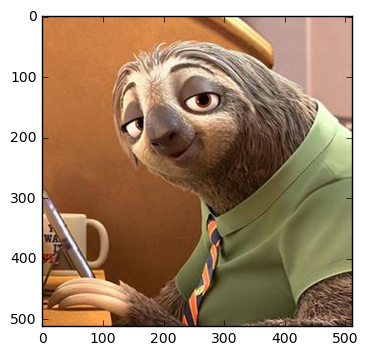

In [11]:
im_show(content)

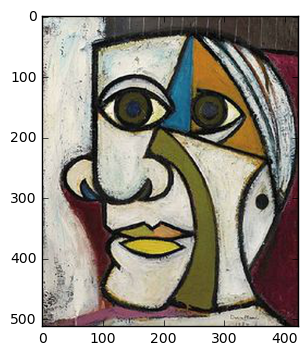

In [12]:
im_show(style)

# In my own

In [13]:
content.shape, style.shape

((1, 512, 512, 3), (1, 512, 422, 3))

In [14]:
vgg = VGG()

## get feature maps

content p, synthesis x, style a

In [15]:
content = vgg.preproc(content)
style = vgg.preproc(style)

In [16]:
# build vgg19 net
tf.reset_default_graph()

style_image = tf.placeholder(tf.float32, [None] + list(style.shape[1:]))
content_image = tf.placeholder(tf.float32, [None] + list(content.shape[1:]))
synthesis_image = tf.Variable(initial_value=content, trainable=True, dtype=tf.float32)

style_features = vgg.build_net(style_image)
content_features = vgg.build_net(content_image)
synthesis_features = vgg.build_net(synthesis_image)

In [17]:
for cl in content_layers:
    print 'CONTENT:', cl, content_features[cl].shape

CONTENT: conv4_2 (?, 64, 64, 512)


In [18]:
for sl in style_layers:
    print 'STYLE:', sl, style_features[sl].shape

STYLE: relu1_1 (?, 512, 422, 64)
STYLE: relu2_1 (?, 256, 211, 128)
STYLE: relu3_1 (?, 128, 106, 256)
STYLE: relu4_1 (?, 64, 53, 512)
STYLE: relu5_1 (?, 32, 27, 512)


### Gram matrix

In [19]:
def gram_matrix(features):
    c = features.shape[-1].value
    flat = tf.reshape(features, [-1, c]) # N=1 이라서 이렇게 함
    return tf.matmul(tf.transpose(flat), flat)

In [20]:
for sl in style_layers:
    gram = gram_matrix(style_features[sl])
    print 'GRAM:', sl, gram

GRAM: relu1_1 Tensor("MatMul:0", shape=(64, 64), dtype=float32)
GRAM: relu2_1 Tensor("MatMul_1:0", shape=(128, 128), dtype=float32)
GRAM: relu3_1 Tensor("MatMul_2:0", shape=(256, 256), dtype=float32)
GRAM: relu4_1 Tensor("MatMul_3:0", shape=(512, 512), dtype=float32)
GRAM: relu5_1 Tensor("MatMul_4:0", shape=(512, 512), dtype=float32)


## Losses

In [21]:
# style_loss
style_loss = 0.
for i, sl in enumerate(style_layers):
    style_f = style_features[sl]
    syn_f = synthesis_features[sl]
    h, w, c = style_f.shape[1:]
    
    G = gram_matrix(style_f)
    A = gram_matrix(syn_f)
    N = c.value # number of feature map
    M = h.value * w.value # feature map size

    cur_loss = tf.reduce_sum(tf.square(G-A))
    cur_loss /= (4 * N**2 * M**2)
    style_loss += 0.2 * cur_loss # 0.2: style weight per layers

In [22]:
# content loss
content_loss_type = 3
content_loss = 0.
for i, cl in enumerate(content_layers):
    content_f = content_features[cl] # P
    syn_f = synthesis_features[cl] # F

    h, w, c = content_f.shape[1:]
    N = c.value # number of feature map
    M = h.value * w.value # feature map size
    
    if content_loss_type == 1: # original paper
        K = 0.5
    elif content_loss_type == 2: # Artistic style transfer for videos
        K = 1. / (N * M)
    elif content_loss_type == 3: # maybe Preserving Color in Neural Artistic Style Transfer ?
        K = 1. / (2. * N**0.5 * M**0.5)
    cur_loss = K * tf.reduce_sum(tf.square(content_f - syn_f))
    content_loss += cur_loss

In [23]:
# tv loss
h, w, c = synthesis_image.shape[1:]
tv_y_size = ((h-1)*w*c).value
tv_x_size = (h*(w-1)*c).value
tv_loss_y = tf.nn.l2_loss(synthesis_image[:, 1:, :, :] - synthesis_image[:, :-1, :, :]) / tv_y_size
tv_loss_x = tf.nn.l2_loss(synthesis_image[:, :, 1:, :] - synthesis_image[:, :, :-1, :]) / tv_x_size
tv_loss = 2 * (tv_loss_y + tv_loss_x)

In [24]:
total_loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss

## Optimize

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [27]:
n_iter = 1000
it = 0

def callback(tl, cl, sl, tvl, image):
    global it
    it += 1
    if it == 1 or it % 100 == 0:
        print('[{}/{}] {:.2e} = {:.2e} + {:.2e} + {:.2e} (total_loss = content_loss + style_loss + tv_loss)'.
              format(it, n_iter, tl, cl*content_weight, sl*style_weight, tvl*tv_weight))
        im_show(vgg.unproc(image[0]))

optimizer = tf.contrib.opt.ScipyOptimizerInterface(total_loss, method='L-BFGS-B', options={'maxiter': n_iter})

[1/1000] 1.85e+09 = 7.09e-08 + 1.85e+09 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


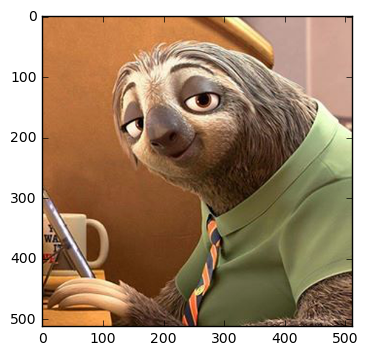

[100/1000] 9.76e+06 = 7.77e+05 + 8.99e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


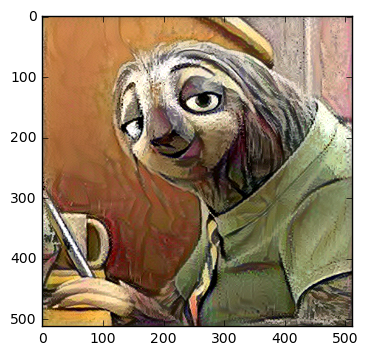

[200/1000] 4.61e+06 = 8.65e+05 + 3.74e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


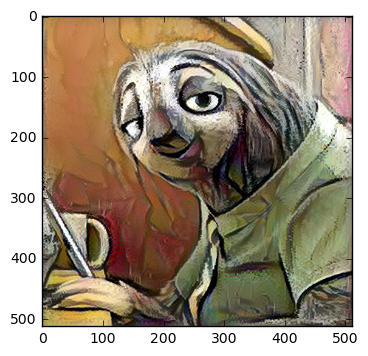

[300/1000] 3.38e+06 = 8.87e+05 + 2.49e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


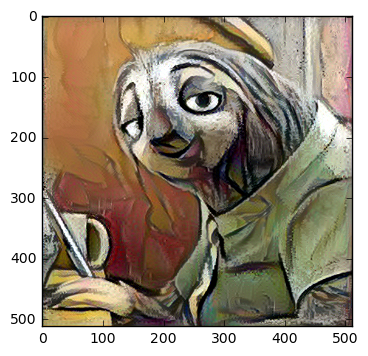

[400/1000] 2.80e+06 = 9.02e+05 + 1.90e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


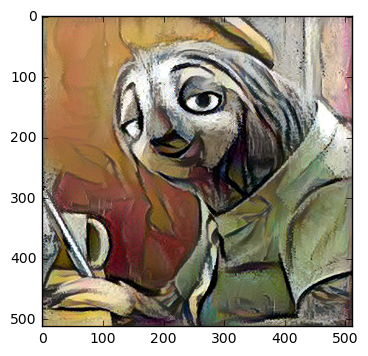

[500/1000] 2.47e+06 = 9.12e+05 + 1.56e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


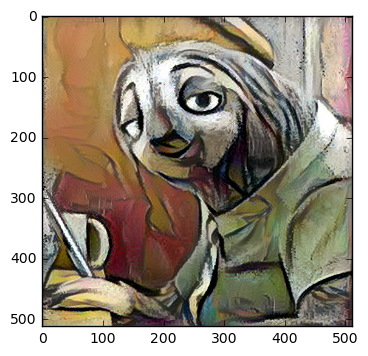

[600/1000] 2.25e+06 = 9.17e+05 + 1.34e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


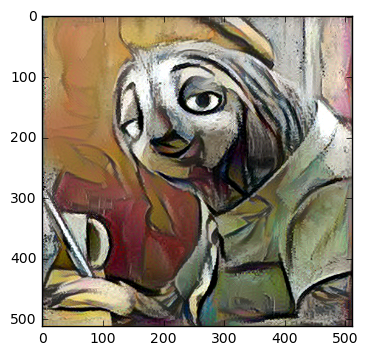

[700/1000] 2.10e+06 = 9.21e+05 + 1.18e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


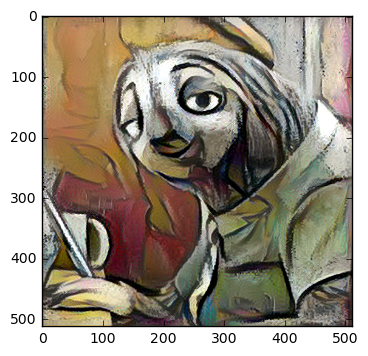

[800/1000] 1.98e+06 = 9.24e+05 + 1.06e+06 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


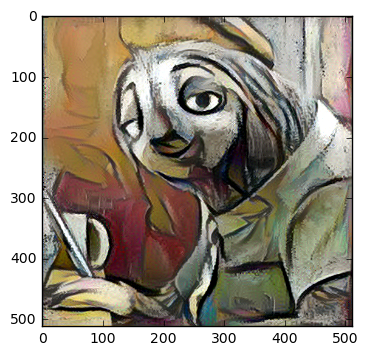

[900/1000] 1.90e+06 = 9.24e+05 + 9.74e+05 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


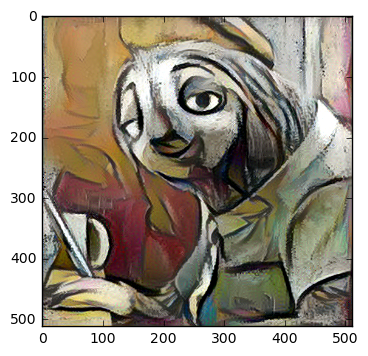

[1000/1000] 1.83e+06 = 9.23e+05 + 9.12e+05 + 0.00e+00 (total_loss = content_loss + style_loss + tv_loss)


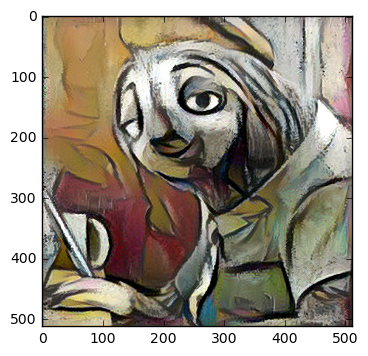

INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 1812683.875000
  Number of iterations: 1001
  Number of functions evaluations: 1040


In [28]:
optimizer.minimize(sess, {style_image: style, content_image: content}, 
                   fetches=[total_loss, content_loss, style_loss, tv_loss, synthesis_image], loss_callback=callback)

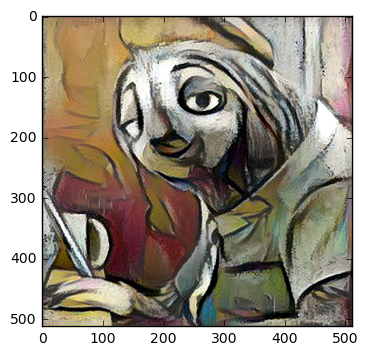

In [30]:
final_image = sess.run(synthesis_image)
final_image = vgg.unproc(final_image)
final_image = np.clip(final_image, 0.0, 255.0)
im_show(final_image[0])

In [31]:
im.save(final_image[0], 'result.jpg')